# XGBoost Modeling

## Objectives
* Load data
* Tune hyper parameters for each version of the data
* Select a model
* Examine results
* Save results

## Tools Used
* Pickle
* Numpy
* Pandas
* Matplotlib
* Sklearn
* Imblearn

#### Load data

I will start by importing the necessary libraries.

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_recall_curve, auc, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
import time
from modeling_functions import *

import warnings
warnings.filterwarnings("ignore") 

## Pickle

In [5]:
# Load data
pickle_in = open("engineered_data.pickle", "rb")
df = pickle.load(pickle_in)
pickle_in.close()

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df)


# combine train, val and test data
X = pd.concat([X_train, X_val, X_test], axis=0)
y = pd.concat([y_train, y_val, y_test], axis=0)


(14275, 53) (42721, 53) (42722, 53) (14275,) (42721,) (42722,)


In [6]:
# Load data
pickle_in = open("olr_keys_n_components.pickle", "rb")
olr_keys_n_components = list(pickle.load(pickle_in))
pickle_in.close()

# Sanity Check
print(olr_keys_n_components)

[('s1_r1_o1', 19), ('s1_r1_o3', 18), ('s1_r2_o1', 17), ('s1_r2_o3', 16), ('s2_r1_o1', 26), ('s2_r1_o3', 26), ('s2_r2_o1', 21), ('s2_r2_o3', 22), ('s3_r1_o1', 23), ('s3_r1_o3', 25), ('s3_r2_o1', 17), ('s3_r2_o3', 20)]


## Tune hyperparameters

My goal for this project is to create a model that can help alert a credit lender to suspicious activity. <br><br>

For this reason I want to have low false negatives, so I will be using recall as my main metric. High recall will mean a low amount of fradulent transactions are left undetected. <br><br>

My second metric will be precision because I do not want false positives either. low precision would cause the model to flag too large an amount of the data as likely to be fraudulent. If the credit lender chose to take preventative action on say, every other transaction, then that would be a nuisance to both the credit lender and the clients. <br><br>

However precision does not need to be nearly as high as recall. If recall was say %80 then I would have potentially stopped %80 percent of fraud and if precision was say %20 then less than 1 out of 100 transactions would be flagged as suspicous to fraud, because in this dataset fraud accounts for %0.17 percent of the data I was  given. <br><br> 

F1-score is the harmonic mean of recall and precision. It is not the best metric to use though because it is important that recall is high, but precision can get away with being much lower. However I will use it in parameter tuning.<br><br>

The metrics mentioned above are calculated by comparing the known values to the model's predicted values. The simplified formulas for precision and recall are showed below. 
<img src="../Images/Precision_Recall.png"><br>
<a href="https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9">Image Source</a> 
<br><br>

To tune the hyperparameters I will use my own function called customGridSearch. It has a doc string attached. The function will go through the data transforming it according to the function's parameters and return the cross validation scores for each method as well as for the best combination of parameters.

## XGBClassifier

In [7]:
# Instantiate classifer
clf = XGBClassifier()

# parameter grid
params = { 
    "max_depth": [2, 3, 4]
}

Warning the following cell 5 took minutes to run!

In [8]:
# Tune hyperparameters for all scalers 
# Implementing SMOTE
# No outliers removed
# No PCA

t1 = time.time()

# Record results
results_o1 = {}
scaler_str = ["Min-Max", "Standard", "Robust"]
for n, scaler in enumerate([MinMaxScaler(), StandardScaler(), RobustScaler()]):
    print(scaler_str[n], '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    results_o1[scaler_str[n]] = customGridSearchCV(clf, params, X_train, y_train, "f1", scaler, SMOTE())
    
t2 = time.time()

print((t2 - t1)/60)

Min-Max ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 4} 
 recall: 0.8722080136402388 
 precision: 0.8870376472615279 
 f1-score: 0.8790225008606681 
precision-recall auc: 0.9151600427771556 

Standard ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 4} 
 recall: 0.8693094629156011 
 precision: 0.9087614032099326 
 f1-score: 0.8873782708040034 
precision-recall auc: 0.9118214764107906 

Robust ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 4} 
 recall: 0.8606138107416881 
 precision: 0.9215154430695496 
 f1-score: 0.8888652453702944 
precision-recall auc: 0.9136080634175524 

5.491796390215556


Warning: The following cell took 4 minutes to run!

In [9]:
# Tune hyperparameters for all scalers 
# Implementing SMOTE
# outliers removed
# No PCA

t1 = time.time()

# Record results
results_o3 = {}
scaler_str = ["Min-Max", "Standard", "Robust"]
for n, scaler in enumerate([MinMaxScaler(), StandardScaler(), RobustScaler()]):
    print(scaler_str[n], '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    results_o3[scaler_str[n]] = customGridSearchCV(clf, params, X_train, y_train, "f1", scaler, SMOTE(), outlier_removal=True)
    
t2 = time.time()

print((t2 - t1)/60)

Min-Max ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 2} 
 recall: 0.8780477408354648 
 precision: 0.8117894084133322 
 f1-score: 0.8413797769791754 
precision-recall auc: 0.8902336487346645 

Standard ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 4} 
 recall: 0.924552429667519 
 precision: 0.40280989938753536 
 f1-score: 0.5599052547040163 
precision-recall auc: 0.887562267601701 

Robust ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 3} 
 recall: 0.9361466325660699 
 precision: 0.20868590755242789 
 f1-score: 0.340073725554401 
precision-recall auc: 0.8838466867273114 

1.9280571619669595


Warning: The following cell took 8 minutes to run!

In [10]:
# Tune hyperparameters for all scalers 
# Implementing NearMiss
# No outliers removed
# PCA

t1 = time.time()


# Get correct scaler_str's and n_components (for PCA)
o1_n_components = []
for key, n in olr_keys_n_components:
    if 'r1_o1' in key:
        o1_n_components.append(n)
        

# Record results
results_o1_p = {}
scaler_str = ["Min-Max", "Standard", "Robust"]
for n, scaler, k in zip([0,1,2],[MinMaxScaler(), StandardScaler(), RobustScaler()], o1_n_components):
    print(scaler_str[n], '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    results_o1_p[scaler_str[n]] = customGridSearchCV(clf, params, X_train, y_train, 'f1', scaler, SMOTE(), pca=PCA(k))
t2 = time.time()

print((t2 - t1)/60)

Min-Max ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 4} 
 recall: 0.8605711849957375 
 precision: 0.7158450048084195 
 f1-score: 0.7787172972434511 
precision-recall auc: 0.8684079460047821 

Standard ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 4} 
 recall: 0.8635123614663257 
 precision: 0.7972892027567429 
 f1-score: 0.8278897574611431 
precision-recall auc: 0.8825033698804858 

Robust ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 4} 
 recall: 0.8664109121909634 
 precision: 0.7970468459326907 
 f1-score: 0.829808251192145 
precision-recall auc: 0.8900177513201157 

3.8157058715820313


Warning: this cell took 8 minutes to run!

In [11]:
# Tune hyperparameters for all scalers 
# Implementing SMOTE
# Outliers removed
# PCA

t1 = time.time()


# Get correct scaler_str's and n_components (for PCA)
o3_n_components = []
for key, n in olr_keys_n_components:
    if 'r1_o3' in key:
        o3_n_components.append(n)
        

# Record results
results_o3_p = {}
for n, scaler, k in zip([0,1,2],[MinMaxScaler(), StandardScaler(), RobustScaler()], o3_n_components):
    print(scaler_str[n], '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    results_o3_p[scaler_str[n]] = customGridSearchCV(clf, params, X_train, y_train, "f1", scaler, SMOTE(), 
                                                     outlier_removal=True, pca=PCA(k))
    
t2 = time.time()

print((t2 - t1)/60)

Min-Max ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 3} 
 recall: 0.8575873827791988 
 precision: 0.6459553370038807 
 f1-score: 0.7340988696665851 
precision-recall auc: 0.8525106679173104 

Standard ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 3} 
 recall: 0.9448422847399829 
 precision: 0.1708611522880727 
 f1-score: 0.2867343157221559 
precision-recall auc: 0.8491317336688157 

Robust ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
{'max_depth': 3} 
 recall: 0.915771526001705 
 precision: 0.3391809622433181 
 f1-score: 0.49352976814526606 
precision-recall auc: 0.8612471522500755 

1.357500684261322


# Model selection

Now I will look through each models scores manually and conclude which one is the best performing model.

My choice a model using the data scaled with StandardScaler, without the outliers removed and without PCA because it had a high cross validated recall of ~%87 and precision of ~%91
The models parameters are as follows: <br> <br>
{'max_depth': 4} 

In [12]:
model = XGBClassifier(max_depth=4)

In [13]:
def engineer(X_train, X_test, y_train, y_test):
    # scaling
    rs = StandardScaler()
    X_train = rs.fit_transform(X_train)
    X_test = rs.transform(X_test)
    
    # resampling
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test

# Choosing the right threshold

In [14]:
X_train_, X_val_, y_train_, y_val_ = engineer(X_train, X_val, y_train, y_val)

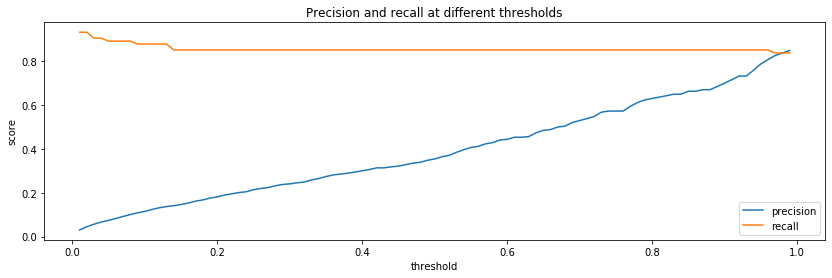

In [15]:
model.fit(X_train_, y_train_)
probs = model.predict_proba(X_val_)[:,1]

thresholds = np.array(range(1, 100))/100
precisions = []
recalls = []

for threshold in thresholds:
    result = [0 if prob < threshold else 1 for prob in probs]
    precisions.append(precision_score(y_val, result))
    recalls.append(recall_score(y_val, result))

plt.figure(figsize=(14, 4))
plt.title("Precision and recall at different thresholds")
plt.xlabel("threshold")
plt.ylabel("score")
plt.plot(thresholds, precisions, label="precision")
plt.plot(thresholds, recalls, label="recall")
plt.legend()
plt.show()

    

It seems the best threshold is about 0.97

In [16]:
threshold = 0.97

## Goodness of fit: How much data to train on

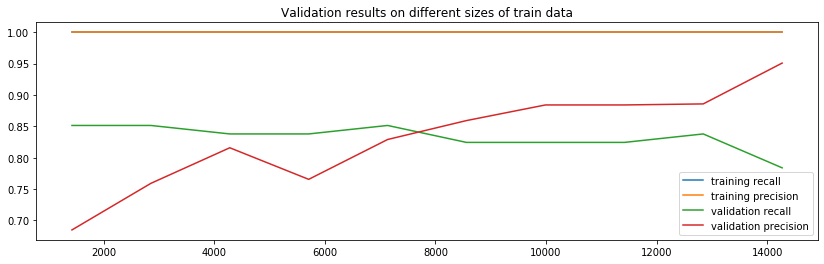

In [17]:
size_plot(model, X_train, X_val, y_train, y_val, StandardScaler(), threshold=threshold)

In this scenario It seems that 11000 rows would be best.

## Holdout Validation
Now I will run the model on the test data which has yet to be seen by the model.

In [18]:
# run data on test set

# engineer data
X_train_, X_test_, y_train_, y_test_ = engineer(X_train, X_test, y_train, y_test)

# fit model to entire train set
model.fit(X_train_[:11000], y_train_[:11000])

# run model on test set
probs = model.predict_proba(X_test_)[:,1]

y_hat = [0 if prob < threshold else 1 for prob in probs]

# get results
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.88      0.77      0.82        74

    accuracy                           1.00     42722
   macro avg       0.94      0.89      0.91     42722
weighted avg       1.00      1.00      1.00     42722



The testing scores are %77 recall and %88 precision

# Precision Recall Curve
Now I will display the precision recall curve which shows all the posible precision and recall values possible if the model had different thresholds.

AUC: 0.8161508782097849


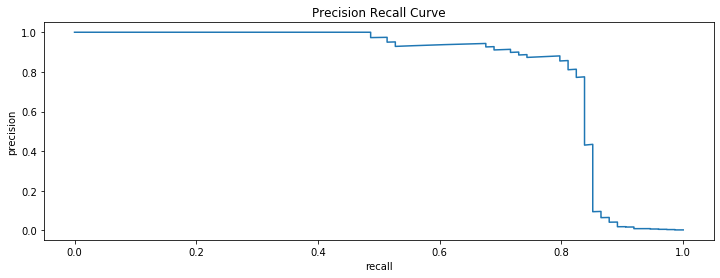

In [19]:
# Plot precision recall curve and the area under that curve.

# get precision, recall, and threshold values
p, r, th = precision_recall_curve(y_test_, probs)

# find and print AUC
print("AUC: {}".format(auc(r, p)))

# plot curve
plt.figure(figsize=(12, 4))
plt.plot(r, p)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Precision Recall Curve")
plt.show()

## Cross Validation

I will check the scores at each split of the model to make sure it is not over fitting to a specific split.

In [20]:
# print cross validation scores
customCV(model, X, y, StandardScaler(), SMOTE(), outlier_removal=False,
         pca=None, print_splits=True, threshold=threshold)

split 1
recall: 0.8081
precision: 0.9195
f1: 0.8602
precision-recall auc: 0.8746
split 2
recall: 0.8182
precision: 0.9529
f1: 0.8804
precision-recall auc: 0.8723
split 3
recall: 0.7551
precision: 0.9867
f1: 0.8555
precision-recall auc: 0.8406
split 4
recall: 0.8163
precision: 0.9524
f1: 0.8791
precision-recall auc: 0.8785
split 5
recall: 0.8265
precision: 0.9878
f1: 0.9
precision-recall auc: 0.8735
Mean Scores:
Mean recall: 0.8048
Mean precision: 0.9599
Mean f1: 0.8751
Mean auc: 0.8679 



[0.8048443619872192,
 0.9598667806904089,
 0.8750524089945569,
 0.8678754826457906]

It appears to not be overfitting to a particular split. <br>
The Cross validated scores are %80 recall and %96 precision

## Save Data

Now I will save the data along with a string to represent the transformations done to the data

In [21]:
pickle_out = open("Models/XGB.pickle", "wb")
pickle.dump([model, 's1_r1_o1, pca None'], pickle_out)
pickle_out.close()